# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import sys
import pickle
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

% matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# if you want to use the previously processed and cleaned data, then "YES", otherwise "NO"
load_user_offer_matrix = "YES"

# 1 Preprocessing

#### 1.1 Explore and clean Portfolio data

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


###### 1.1.1 One hot encoding of categorical variables
From inspection of the portfolio, we can see that email is used for all offers, and so we will not need to add a specific column to one-hot-encode email, as it would be redundant information. 

In [5]:
portfolio['channel_mobile'] = 0
portfolio['channel_social'] = 0
portfolio['channel_web'] = 0

In [6]:
portfolio['type_bogo'] = 0
portfolio['type_discount'] = 0
portfolio['type_informational'] = 0

In [7]:
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 'mobile' in x) * 1
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 'social' in x) * 1
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 'web' in x) * 1
portfolio = portfolio.drop(['channels'], axis=1)

In [8]:
portfolio['type_bogo'] = portfolio['offer_type'].apply(lambda x: 'bogo' in x) * 1
portfolio['type_discount'] = portfolio['offer_type'].apply(lambda x: 'discount' in x) * 1
portfolio['type_informational'] = portfolio['offer_type'].apply(lambda x: 'informational' in x) * 1
portfolio = portfolio.drop(['offer_type'], axis=1)

In [9]:
# convert duration into hours
portfolio['duration'] = portfolio['duration'] * 24

# rename 'id' column to 'offer_id'
portfolio.rename(columns  = {'id': 'offer_id'}, inplace = True)

In [10]:
portfolio

,difficulty,duration,offer_id,reward,channel_mobile,channel_social,channel_web,type_bogo,type_discount,type_informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,0,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,0,1,0,1,0


#### 1.2 Explore and clean Profile data

###### 1.2.1 Data exploration

In [11]:
profile.shape

(17000, 5)

In [12]:
profile.sample(10)

,age,became_member_on,gender,id,income
16635,63,20161220,M,8376484728e64b80bfb197c145adef3e,31000.0
9439,60,20160220,F,99d795545dbb4837b7ed00644ffbd367,57000.0
12920,91,20170425,M,bf1b561379e04f6cb6c21901805c3c95,59000.0
4217,47,20150810,F,6c2c85ad5b244122a70425e6be34e0fd,30000.0
16377,55,20160508,M,f3934f05d51f47c7a470661cbb774075,40000.0
12785,118,20161021,None,205d1ace508649fab7429043d9203f6b,NaN
8520,58,20180703,M,53a2acf674384a5784743e8b1b9cc2b5,43000.0
2152,118,20160703,None,d018a8a3bef243b1b37414073ef5e74a,NaN
11514,89,20171126,F,1ee7f93a43754db1993f50e6a877bc01,39000.0
15345,44,20170830,M,d3c29f3cb6b447c89daed838ae5abd25,51000.0


In [13]:
# rename 'id' column to 'customer'
profile.rename(columns = {'id': 'customer'}, inplace=True)

In [14]:
# SEARCH FOR NaN

In [15]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
customer               0
income              2175
dtype: int64

We find exactly the same number of NaN for gender and for income. This suggests that there are 2175 customers who declined to disclose both their gender and income.

In [16]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [17]:
profile.describe(include=['object'])

,gender,customer
count,14825,17000
unique,3,17000
top,M,d7a161d80543448caa3217adf68bc965
freq,8484,1


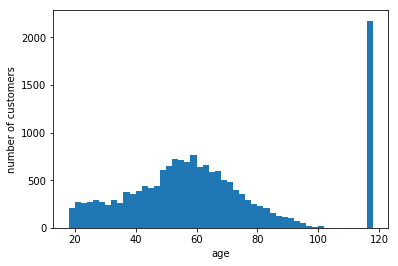

In [18]:
plt.hist(profile['age'], bins=50);
plt.xlabel('age')
plt.ylabel('number of customers')
plt.show()

In [19]:
len(profile[profile['age']==118])

2175

In [20]:
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

We note that there is a relatively high number (2175) of customers with the age of 118. From the unique ages in the profile, there are no customers between the age of 101 and 118. These two observations suggest that age 118 is a proxy for "age not disclosed by customer" or "age unknown". 

In [21]:
checkprofile = profile[profile['age'] == 118]

In [22]:
checkprofile.head()

,age,became_member_on,gender,customer,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [23]:
checkprofile.isna().sum()

age                    0
became_member_on       0
gender              2175
customer               0
income              2175
dtype: int64

We conclude that the 2175 customers with age 118 are the same 2175 customers who did not provide information about their gender or their income. 

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


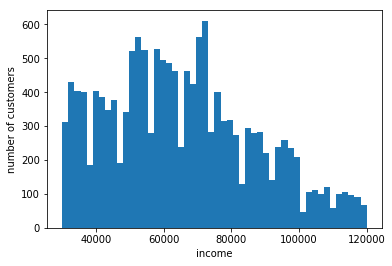

In [24]:
plt.hist(profile['income'], bins=50, range=(30000,120000)); # IGNORE NaN VALUES FOR INCOME PLOT
plt.xlabel('income')
plt.ylabel('number of customers')
plt.show()

In [25]:
profile.groupby(['gender'])['customer'].count()

gender
F    6129
M    8484
O     212
Name: customer, dtype: int64

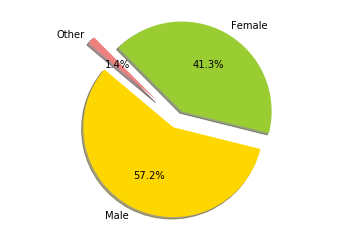

In [26]:
labels = 'Male', 'Female', 'Other'
sizes = [8484, 6129, 212]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0.1, 0.3)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

We note that there are relatively few people who identify as gender "Other".

**Overall** we find there are no issues with the data, apart from the 2175 customer records where age, gender and income are unknown.

#### 1.3 Explore and clean Transcript data

In [27]:
transcript.shape

(306534, 4)

In [28]:
transcript.tail(10)

,event,person,time,value
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [29]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

###### 1.3.1 Check data quality

In [30]:
# CHECK WHAT ENTRIES APPEAR IN EVENT COLUMN
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [31]:
# CHECK WHAT KEYS APPEAR IN VALUE COLUMN
allkeys = {}
for n in range(len(transcript)):
    allkeys = {**allkeys, **transcript.iloc[n,3]}
print(allkeys.keys())

dict_keys(['offer id', 'amount', 'offer_id', 'reward'])


In [32]:
# CHECK DATA QUALITY - FOR MISSING DATA: 
# IF NOT THEN THERE IS MISSING DATA IN THE PROFILE OR PORTFOLIO DATA FRAME, OR THE TRANSCRIPT DATA FRAME HAS BEEN CORRUPTED 

In [33]:
# a) CHECK THAT ALL PERSONS IN PERSON COLUMN HAVE AN ENTRY IN THE PROFILE DATA FRAME
transcript_persons = set(transcript['person'])
profile_ids = set(profile['customer'])
transcript_persons.difference(profile_ids) # returns transcript_persons NOT in profile_ids. Should be empty set.

set()

In [34]:
# b) CHECK THAT ALL OFFER IDS IN VALUE COLUMN HAVE AN ENTRY IN THE PORTFOLIO DATA FRAME
# SPLIT VALUE COLUMN INTO SEPARATE COLUMNS FIRST 

In [35]:
transcript.insert(4, 'offer_id', 0)
transcript.insert(5, 'amount', 0)
transcript.insert(6, 'reward', 0)

In [36]:
def get_offer_id(anydict):
    # Obtain offer id from either of the 2 offer keys
    temp1 = anydict.get('offer_id')
    temp2 = anydict.get('offer id')
    if temp1 != None:
        offerid = temp1
    elif temp2 != None:
        offerid = temp2
    else:
        offerid = ''
    return offerid

In [37]:
transcript['offer_id'] = transcript['value'].apply(get_offer_id)
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward', 0))
transcript = transcript.drop(['value'], axis=1)

In [38]:
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [39]:
# CHECK THAT ALL OFFER_ID IN TRANSCRIPT ARE IN PROFILE
transcript_offer_ids = set(transcript['offer_id'])
portfolio_ids = set(portfolio['offer_id'])
transcript_offer_ids.difference(portfolio_ids) # returns transcript_offer_ids NOT in portfolio. Should be empty set.

{''}

**Overall** We note that offer completion is marked in the transcript for BOGO and discount offers, but not for informational offers. We have not found any other issues in the data quality checks of the transcript. 

In [40]:
# drop unwanted columns
transcript2 = transcript.drop(['amount', 'reward'], axis=1)
transcript2 = transcript2.sort_values(by=['person', 'time'], ascending=[True, True])

## 1.4 Setting up / loading cleaned data files

### 1.4.1 Load pre-processed data or initialise file for pre-processing

We will be pre-processing the data, before analysis. Because this can take an appreciable amount of computing time, there is the option to save the pre-processed data, and then we can re-start in a later session from the saved version of the data, rather than having to pre-process again. 

In [41]:
# load previously determined user_offer matrix and user_transaction matrix
if load_user_offer_matrix == "YES":
    # use this to open a previously created user_offer matrix
    picklefile = open('user_offer_mx', 'rb')
    user_offer = pickle.load(picklefile)
    picklefile.close()
    
    # use this to open a previously created user_transaction matrix
    picklefile = open('user_trans_mx', 'rb')
    user_offer = pickle.load(picklefile)
    picklefile.close()
    
    
else:
    # Initialise user_offer matrix
    all_persons = transcript2['person'].unique()
    colnames = ['person', 'offer_0r', 'offer_1r', 'offer_2r', 'offer_3r', 'offer_4r', 'offer_5r',
           'offer_6r', 'offer_7r', 'offer_8r', 'offer_9r', 'offer_0c', 'offer_1c', 'offer_2c', 'offer_3c', 'offer_4c', 'offer_5c',
           'offer_6c', 'offer_7c', 'offer_8c', 'offer_9c', 'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', 'offer_5v',
           'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v']
    user_offer = pd.DataFrame(0, index=np.arange(0,len(all_persons)), columns=colnames)
    user_offer['person'] = all_persons
    
    # Initialise user_trans matrix
    all_persons = transcript2['person'].unique()
    colnames = ['person', 'offer_0tval', 'offer_1tval', 'offer_2tval', 'offer_3tval', 'offer_4tval', 'offer_5tval',
           'offer_6tval', 'offer_7tval', 'offer_8tval', 'offer_9tval', 'all_trans_val', 'n_all_trans']
    user_trans = pd.DataFrame(0, index=np.arange(0,len(all_persons)), columns=colnames)
    user_trans['person'] = all_persons

#### 1.4.2 Miscellaneous preparatory steps for later pre-processing

In [42]:
# create dictionaries for lookup of offer ids and durations
all_offers = list(portfolio['offer_id'])
all_durations = list(portfolio['duration'])
cols = ['offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
       'offer_6', 'offer_7', 'offer_8', 'offer_9']
dict_offer_ids = dict(zip(all_offers,cols))
dict_offer_durations = dict(zip(cols,all_durations))

In [43]:
# update transcript with offer_id marked up according to the dictionary defined above, for ease of reading
transcript2 = transcript2[transcript2['offer_id'].notnull()].copy()
transcript2['offer_id'] = transcript2['offer_id'].map(dict_offer_ids)
transcript2['offer_id'].fillna('', inplace=True) # for transaction events, there is no offer_id

In [44]:
transcript2.head(10)

,event,person,time,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,offer_7
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,offer_7
89291,transaction,0009655768c64bdeb2e877511632db8f,228,
113605,offer received,0009655768c64bdeb2e877511632db8f,336,offer_2
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,offer_2
153401,offer received,0009655768c64bdeb2e877511632db8f,408,offer_8
168412,transaction,0009655768c64bdeb2e877511632db8f,414,
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,offer_8
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,offer_8
204340,offer received,0009655768c64bdeb2e877511632db8f,504,offer_6


## 1.5 Determine number of fulfilled orders

We cannot just take the transcript event "offer completed" as meaning an offer is genuinely completed. We need to determine which offers are "fulfilled". By this we mean:

**For bogo / discount offers :** 
> the offer was viewed before the "offer completion", and the offer completion occured before the offer expired
  (duration taken from when the offer was received).
  
**For informational offers :**
> there is a qualifying transaction that occurred after the offer was viewed, and the transaction occured before the offer
 expired (duration taken from when the offer was received). Because the transcript does not directly indicate which transactions are associated with the completion of an informational offer, we have used the assumption that a qualifying transaction is a transaction that is not associated with any other offer completion.

##### 1.5.1 Define functions that will be used to determine fulfilled orders

In [45]:
def count_offers_completed():
    '''
    Purpose: for a given customer, determine the offers fulfilled, and create a dataframe "offers_f" to
    record this information. The detailed determination algorithm is done in functions "match_info_offer_trans()"
    and "match_bd_offer()" that are called from "count_offers_completed()".
    
    Also create dataframes "offers_r", "offers_v" and "offers_c" to record which the offers
    received, viewed and completed (i.e. marked as completed in the transcript, but not necessarily "fulfilled") respectively.
    '''  
    
    global trans, offers_v, offers_r, offers_c, offers_f, current_offer
    
    # check if there were any transactions
    trans = temp[temp['event']=='transaction']
    if len(trans) == 0: # no transactions means no offers were completed
        # offer_fulfilled dataframe is set to zero
        offers_f = pd.DataFrame(0, index=np.arange(0, 0), columns=['offer', 'received', 'viewed', 'completed'])
        return
    
    # check if there were any offers viewed
    offers_v = temp[temp['event']=='offer viewed']
    if len(offers_v) == 0: # no offers viewed means no offers were completed
        # offer_fulfilled dataframe is set to zero
        offers_f = pd.DataFrame(0, index=np.arange(0, 0), columns=['offer', 'received', 'viewed', 'completed'])
        return 
    
    ### determine offers fulfilled
    offers_r =temp[temp['event']=='offer received']
    offers_c =temp[temp['event']=='offer completed']
    
    # build offers fulfilled matrix, starting with offers viewed
    offers_f = pd.DataFrame(0, index=np.arange(0, len(offers_v)), columns=['offer', 'received', 'viewed', 'completed'])
    offers_f['viewed'] = offers_v.index
    offers_f['offer'] = offers_v['offer_id'].values

    ## go through each offer viewed and check if it satisfies all conditions for completion
    length = range(len(offers_f))
    for i in length:
        current_offer = offers_f['offer'].values[i]
        #print('current offer', current_offer)
        # first determine if the offer is bogo / discount, or informational
        if (current_offer=='offer_2') | (current_offer=='offer_7'): # potential info offer
            #print('potential info offer')
            # match transactions and offers received to informational offers viewed
            match_info_offer_trans(i)
        
        else: # potential bogo / discount offer
            #print('potential bogo/discount offer')
            #print('i=', i)
            match_bd_offer(i)
    

In [46]:
def match_bd_offer(i):
    '''
    Purpose: for a given customer, determine the bogo / discount offers fulfilled, using the following algorithm:
     a) check in the transcript that there an offer-completing transaction occured after the offer was viewed by the customer
     b) match the offer-completion event in the transcript with an offer-received event. Because there may be multiple instances 
     of the same offer received by the customer, we match to the most recent one. (We assume that recent offers have more 
     influence on customer transaction behaviour than offers from long ago.)
     c) we check that the time elapsed between the offer received and the offer completed is within the duration period of the
     offer.
     d) if all conditions a, b and c are fulfilled, we take the offer to be fulfilled. We record this in the "offer_f"
     dataframe, and we remove the matched offer-received, offer-completion and transaction events from further consideration.
     (We do not want them to be double counted in the next round of offer-transaction matching for this customer.)
    
    Input: i = index referring to the offer that was viewed by the customer.
    '''  
    global offers_v, offers_r, offers_c, offers_f, current_offer
    
    t_viewed = temp.loc[offers_f['viewed'].values[i], 'time']
    
    # times at which offers were completed
    t_diffs = offers_c[offers_c['offer_id']==current_offer].time - t_viewed
    t_elapsed = t_diffs[t_diffs >= 0].min()
    #print(t_elapsed)
    
    if np.isnan(t_elapsed) == False: # if there is a transaction after the offer was viewed
        #print('transaction matched\n')
        completion_idx = t_diffs[t_diffs==t_elapsed].index[0]
        # add details to offers_f matrix
        offers_f['completed'].values[i] = completion_idx
        
        # match current_offer to offer received
        t_diffs_r = t_viewed - offers_r[offers_r['offer_id']==current_offer].time
        #print(t_diffs_r)
        t_elapsed_r = t_diffs_r[t_diffs_r >= 0].min()
        #print(t_elapsed_r)
        receipt_idx = t_diffs_r[t_diffs_r==t_elapsed_r].index[0]
        
        # check that offer was completed within duration
        t_received_to_completed = t_elapsed_r + t_elapsed
        #print(t_received_to_completed)
        duration = dict_offer_durations[current_offer]
        #print(duration)
        if t_received_to_completed <= duration: # offer completed within duration
            #print('offer completed within duration\n')
            # add details to offers_f matrix
            offers_f['received'].values[i] = receipt_idx
            
            # drop completed and receipted lines (so they aren't counted again in the next offer-matching)
            offers_c = offers_c.drop(completion_idx)
            #display(offers_c)
            offers_r = offers_r.drop(receipt_idx)
            #display(offers_r)
            
        else: # offer not completed within duration
            #print('completion too late\n')      
            offers_f['received'].values[i] = -999 # use dummy value to indicate 'None' 
    else:
        #print('no transactions after offer was viewed\n')
        offers_f['completed'].values[i] = -999 # use dummy value to indicate 'None' 
        offers_f['received'].values[i] = -999 # use dummy value to indicate 'None' 

In [47]:
def match_info_offer_trans(i):

    """
    Purpose: match informational offers with transactions. The right transaction to match is the one that:
                a) is not associated with a BOGO or discount offer completion, and
                b) is the next occuring of these transactions after the offer is viewed, and
                c) occurs within the expiry time for the offer.
        '''
    Purpose: for a given customer, determine the informational offers fulfilled, using the following algorithm:
     a) check in the transcript that there are transactions occuring after the offer was viewed by the customer
     that is not associated with a BOGO or discount offer completion
     b) take the first of these transactions that occurred after the offer was viewed.
     (We assume that the transaction is most likely to have been influenced by the offer 
     when the offer is freshest in the customer's mind.)
     c) we check that the time elapsed between the offer received and the transaction is within the duration period of the
     offer.
     d) if all conditions a, b and c are fulfilled, we take the offer to be fulfilled. We record this in the "offer_f"
     dataframe, and we remove the matched offer-received and transaction events from further consideration.
     (We do not want them to be double counted in the next round of offer-transaction matching for this customer.)
    
    Input: i = index referring to the offer that was viewed by the customer.
    ''' 
    
    """
    global trans, offers_v, offers_r, offers_c, offers_f, current_offer
    
    
    t_viewed = temp.loc[offers_f['viewed'].values[i], 'time']
    
    df_trans = trans
    filter_t = df_trans['time'].isin(offers_c['time']) # filter out offers associated with bogo / discount offers
    unmatched_trans = df_trans[~filter_t]
    
    
    # times at which unmatched transactions were completed
    t_diffs = unmatched_trans.time - t_viewed
    t_elapsed = t_diffs[t_diffs >= 0].min()
    #print(t_elapsed)
    
    if np.isnan(t_elapsed) == False: # if there is a transaction after the offer was viewed
        #print('transaction matched\n')
        completion_idx = t_diffs[t_diffs == t_elapsed].index[0]
        # add details to offers_f matrix
        offers_f['completed'].values[i] = completion_idx
        
        # match current_offer to offer received
        t_diffs_r = t_viewed - offers_r[offers_r['offer_id']==current_offer].time
        #print(t_diffs_r)
        t_elapsed_r = t_diffs_r[t_diffs_r >= 0].min()
        #print(t_elapsed_r)
        receipt_idx = t_diffs_r[t_diffs_r == t_elapsed_r].index[0]
        
        # check that offer was completed within duration
        t_received_to_completed = t_elapsed_r + t_elapsed
        #print(t_received_to_completed)
        duration = dict_offer_durations[current_offer]
        #print(duration)
        if t_received_to_completed <= duration: # offer completed within duration
            #print('offer completed within duration\n')
            # add details to offers_f matrix
            offers_f['received'].values[i] = receipt_idx
            
            # drop transaction and offer receipted lines (so they aren't counted again in the next offer-matching)
            trans = trans.drop(completion_idx)
            #display(trans)
            offers_r = offers_r.drop(receipt_idx)
            #display(offers_r)
            
        else: # offer not completed within duration
            #print('completion too late\n')      
            offers_f['received'].values[i] = -999 # use dummy value to indicate 'None' 
    else:
        #print('no transactions after offer was viewed\n')
        offers_f['completed'].values[i] = -999 # use dummy value to indicate 'None' 
        offers_f['received'].values[i] = -999 # use dummy value to indicate 'None' 


### 1.5.2 Main pre-processing loop to determine and record fulfilled orders

**Outline**
1. Go through each customer in turn, extract their records from the transcript, and determine the offers that the customer fulfilled. Also note which offers were not fulfilled. Record this information in the `user_offer` dataframe.

2. Determine the value of the transctions that are associated with each fulfilled order, and also value of 
transactions that are not associated with any fulfilled order, i.e. spending that the customer made that was uninfluenced by any offers. Record all this information in the `user_trans` dataframe.

In [48]:
if load_user_offer_matrix == "NO": #i.e. we are not using saved pre-processed data

    ### loop over all customers to determine completed offers for each, and record in user-offer matrix
    n_persons = range(len(user_offer))

    for pers in n_persons:

        # counter to track progress
        if pers % 100 == 0:
            print(pers, end=" ")

        temp = transcript2[transcript2['person']==user_offer['person'].values[pers]]

        # determine offers received
        offer_r_mx = temp[temp['event']=='offer received']['offer_id'].value_counts().to_frame()
        length = range(len(offer_r_mx))
        for j in length:
            offer_rec = offer_r_mx.index[j]
            n_rec = offer_r_mx['offer_id'].values[j]
            if offer_rec == 'offer_0':
                user_offer.iloc[pers,1] = n_rec
            elif offer_rec == 'offer_1':
                user_offer.iloc[pers,2] = n_rec
            elif offer_rec == 'offer_2':    
                user_offer.iloc[pers,3] = n_rec
            elif offer_rec == 'offer_3':   
                user_offer.iloc[pers,4] = n_rec
            elif offer_rec == 'offer_4':     
                user_offer.iloc[pers,5] = n_rec
            elif offer_rec == 'offer_5':    
                user_offer.iloc[pers,6] = n_rec
            elif offer_rec == 'offer_6':    
                user_offer.iloc[pers,7] = n_rec
            elif offer_rec == 'offer_7':    
                user_offer.iloc[pers,8] = n_rec
            elif offer_rec == 'offer_8':    
                user_offer.iloc[pers,9] = n_rec
            elif offer_rec == 'offer_9':    
                user_offer.iloc[pers,10] = n_rec
                
        # determine offers viewed
        offer_v_mx = temp[temp['event']=='offer viewed']['offer_id'].value_counts().to_frame()
        length = range(len(offer_v_mx))
        for j in length:
            offer_view = offer_v_mx.index[j]
            n_view = offer_v_mx['offer_id'].values[j]
            if offer_view == 'offer_0':
                user_offer.iloc[pers,21] = n_view
            elif offer_view == 'offer_1':
                user_offer.iloc[pers,22] = n_view
            elif offer_view == 'offer_2':    
                user_offer.iloc[pers,23] = n_view
            elif offer_view == 'offer_3':   
                user_offer.iloc[pers,24] = n_view
            elif offer_view == 'offer_4':     
                user_offer.iloc[pers,25] = n_view
            elif offer_view == 'offer_5':    
                user_offer.iloc[pers,26] = n_view
            elif offer_view == 'offer_6':    
                user_offer.iloc[pers,27] = n_view
            elif offer_view == 'offer_7':    
                user_offer.iloc[pers,28] = n_view
            elif offer_view == 'offer_8':    
                user_offer.iloc[pers,29] = n_view
            elif offer_view == 'offer_9':    
                user_offer.iloc[pers,30] = n_view

        # determine offers that qualify as fully completed
        count_offers_completed()    
        #display(offers_f)

        # record offers fulfilled in user_offer matrix
        # first filter out any lines with -999 (which denote offers do not qualify as fully completed)
        offer_f_mx = offers_f[(offers_f['received'] != -999) & (offers_f['completed'] != -999)]['offer'].value_counts().to_frame()

        length = range(len(offer_f_mx))
        for j in length:
            offer_fin = offer_f_mx.index[j]
            n_fin = offer_f_mx['offer'].values[j]
            if offer_fin == 'offer_0':
                user_offer.iloc[pers,11] = n_fin
            elif offer_fin == 'offer_1':
                user_offer.iloc[pers,12] = n_fin
            elif offer_fin == 'offer_2':    
                user_offer.iloc[pers,13] = n_fin
            elif offer_fin == 'offer_3':   
                user_offer.iloc[pers,14] = n_fin
            elif offer_fin == 'offer_4':     
                user_offer.iloc[pers,15] = n_fin
            elif offer_fin == 'offer_5':    
                user_offer.iloc[pers,16] = n_fin
            elif offer_fin == 'offer_6':    
                user_offer.iloc[pers,17] = n_fin
            elif offer_fin == 'offer_7':    
                user_offer.iloc[pers,18] = n_fin
            elif offer_fin == 'offer_8':    
                user_offer.iloc[pers,19] = n_fin
            elif offer_fin == 'offer_9':    
                user_offer.iloc[pers,20] = n_fin     
                
        
        
        # determine number and value of transactions associated offer completions and otherwise
        
        # total transactions and total value
        all_trans = temp[temp['event']=='transaction']
        all_trans_n = len(all_trans)
        user_trans.iloc[pers,12] = all_trans_n
        
        all_trans_fulldata = transcript.loc[all_trans.index]
        all_trans_val = all_trans_fulldata['amount'].sum()
        user_trans.iloc[pers,11] = all_trans_val
        
        
        # transactions associated with offer completions 
        if len(offer_f_mx) == 0: # there are no offer completions hence no transactions associated with offers
            # set offer_transaction max for this person to be zero
            offer_t_mx = offers_f
            offer_t_mx.insert(4, 'trans_value', 0)
        else: # there are transactions
            # record transaction values of offers fulfilled in user_trans matrix
            offer_t_mx = offers_f[(offers_f['received'] != -999) & (offers_f['completed'] != -999)]
            offer_t_mx.insert(4, 'trans_value', 0)

            length = range(len(offer_f_mx))
            for j in length:
                offer_fin = offer_f_mx.index[j] # refers to each offer that was fulfilled

                # determine transaction amount associated with the fulfilled offer
                completion_idx = offer_t_mx['completed'].values[j]
                if (offer_fin == 'offer_2') | (offer_fin == 'offer_7'):  # informational offers
                    #  the index refers to the transaction that fulfilled the offer
                    t_amt = transcript.loc[completion_idx].amount # using the index, look up the transaction value from the transcript
                else: # bogo or discount offer
                    # the index refers to the offer completion, not the transaction that fulfilled the offer
                    # to find the relevant transaction, need to look in "temp" and consider the row immediately before 
                    # the offer completion. If the row is a transaction, then this is the relevant transaction. 
                    # If the row is not a transaction, consider the row immediately before, until a transaction is found.
                    # Look up the amount associated with the transaction in "transcript". 
                    temp_index = temp.index
                    evt = ''
                    while(evt != 'transaction'): # keep going back row by row in "temp" until you find a transaction
                        mm = temp_index.get_loc(completion_idx) - 1
                        completion_idx = temp_index[mm]
                        evt = temp.loc[completion_idx].event 
                    t_amt = transcript.loc[completion_idx].amount

                offer_t_mx['trans_value'].values[j] = t_amt

                if offer_fin == 'offer_0':
                    user_trans.iloc[pers,1] += t_amt
                elif offer_fin == 'offer_1':
                    user_trans.iloc[pers,2] += t_amt
                elif offer_fin == 'offer_2':    
                    user_trans.iloc[pers,3] += t_amt
                elif offer_fin == 'offer_3':   
                    user_trans.iloc[pers,4] += t_amt
                elif offer_fin == 'offer_4':     
                    user_trans.iloc[pers,5] += t_amt
                elif offer_fin == 'offer_5':    
                    user_trans.iloc[pers,6] += t_amt
                elif offer_fin == 'offer_6':    
                    user_trans.iloc[pers,7] += t_amt
                elif offer_fin == 'offer_7':    
                    user_trans.iloc[pers,8] += t_amt
                elif offer_fin == 'offer_8':    
                    user_trans.iloc[pers,9] += t_amt
                elif offer_fin == 'offer_9':    
                    user_trans.iloc[pers,10] += t_amt 

#### 1.5.3 Save the pre-processed data / load previously saved pre-processed data

In [49]:
if load_user_offer_matrix == "NO":
    # create pickle file if we wish to save user_offer matrix and user_trans mx
    picklefile = open('user_offer_mx', 'wb')
    pickle.dump(user_offer, picklefile)
    picklefile.close()
    
    picklefile = open('user_trans_mx', 'wb')
    pickle.dump(user_trans, picklefile)
    picklefile.close()
else:    
    # use this to open a previously created user_offer matrix
    picklefile = open('user_offer_mx', 'rb')
    user_offer = pickle.load(picklefile)
    picklefile.close()
    
    picklefile = open('user_trans_mx', 'rb')
    user_trans = pickle.load(picklefile)
    picklefile.close()

# 2 Data Analysis

## 2.1 Heuristics 

In this section, we find out which offer was the most popular with each demographic group within the population of customers, without using machine learning models.

#### 2.1.1 Segmentation of customers into demographic groups

We will segment the population of customers by gender, age and income, as follows:

**Gender:** 

Male, Female, Other

**Age:** 

a) 18-24,

b) 25-34,

c) 35-44, 

d) 45-54, 

e) 55-64, 

f) 65-101, 

g) None (i.e. anything above)

**Income:**

I) 29001-45000,

II) 45001-60000,

III) 60001-75000, 

IV) 75001-90000, 

V) 90001-105000, 

VI) 105001-120000  

In [50]:
profile2 = profile

In [51]:
profile2['age_group'] = pd.cut(x=profile2['age'], bins=[17, 24, 34, 44, 54, 64, 101, 118], \
                               labels=['a','b','c','d','e','f', 'None'])
profile2['income_group'] = pd.cut(x=profile2['income'], bins=[29000,45000,60000,75000,90000,105000,120000], \
                                  labels=['I','II','III','IV','V','VI'])

#### 2.1.2 Determine proportion of offers that were fulfilled

The key metric we are interested in is the proportion of offers that were fulfilled. For a given offer, e.g. "offer 1" this is the ratio

    Fulfillment ratio for "offer 1" = Number of "offer 1" instances fulfilled / Number of "offer 1" instances received,

so that a value of 1 means 100% of offer 1 received were fulfilled, and 0 means no offer 1 received were fulfilled.
If no offers were received for a given offer, we will take the value of the metric as zero. The metric measures how "effective" an offer is: the more effective it is, the more it will be fulfilled. An ineffective offer is one that the customer does not care to take up.

The metric is stored in a dataframe `user_offer_rates`, which can be saved and retrieved for a future session.

In [52]:
# determine rate of fulfilment (rate of uptake) of each offer received for each person
if load_user_offer_matrix == "NO":
    
    # Initialise user_offer matrix
    all_persons = transcript2['person'].unique()
    colnames = ['person', 'offer_0_fr', 'offer_1_fr', 'offer_2_fr', 'offer_3_fr', 'offer_4_fr', 'offer_5_fr',
           'offer_6_fr', 'offer_7_fr', 'offer_8_fr', 'offer_9_fr']
    user_offer_rates = pd.DataFrame(0, index=np.arange(0,len(all_persons)), columns=colnames)
    user_offer_rates['person'] = all_persons
    
    # For each offer, 
    #                 fraction =  offers fulfilled / offers received
    # when offers received is nonzero. When offers received is zero, then so is fraction
    for i in range(len(user_offer_rates)):
        # counter to track progress
        if i % 100 == 0:
            print(i, end=" ")
        fraction = [0.0] * 10
        for n in range(10):
            if user_offer.iloc[i,n+1] != 0:
                fraction[n] = user_offer.iloc[i,n+11] / user_offer.iloc[i,n+1]
        user_offer_rates.loc[i, 1:11] = fraction
    
    # create pickle file if we wish to save user_offer_rates matrix
    picklefile = open('user_offer_rates_mx', 'wb')
    pickle.dump(user_offer_rates, picklefile)
    picklefile.close()
else:
    # use this to open a previously created user_offer matrix
    picklefile = open('user_offer_rates_mx', 'rb')
    user_offer_rates = pickle.load(picklefile)
    picklefile.close()

In [53]:
# create a dataframe containing user_offer information and also fulfillment ratio information
# user_offer matrix with all information (absolute return and rates)
user_offer_all = pd.concat([user_offer, user_offer_rates.iloc[:, 1:11]], sort=False, axis=1)
user_offer_all.head()

,person,offer_0r,offer_1r,offer_2r,offer_3r,offer_4r,offer_5r,offer_6r,offer_7r,offer_8r,...,offer_0_fr,offer_1_fr,offer_2_fr,offer_3_fr,offer_4_fr,offer_5_fr,offer_6_fr,offer_7_fr,offer_8_fr,offer_9_fr
0,0009655768c64bdeb2e877511632db8f,0,0,1,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,0,0,1,1,1,1,0,1,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,1,1,0,0,0,0,2,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,1,0,1,0,1,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


We ignore data where age and income are unknown, as we have no reliable way of finding which demographic group this data belongs to; there is too little information to reliably impute age and income here. 

In [54]:
# clean profile2 
# remove entries where age or income are unknown
profile2_cleaned = profile2[(profile2['gender'] != 'None') & (profile2['age_group'] != 'None') &\
                           (profile2['income_group'] != np.nan)]
profile2_cleaned.head()

,age,became_member_on,gender,customer,income,age_group,income_group
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,e,VI
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,f,V
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,f,III
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,f,II
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,e,II


#### 2.1.3 Determine the top offer for each demographic

We define the top offer (i.e. most popular or effective offer) for a given demographic in two ways.

1. The top offer by *Absolute return* - for the demographic as a whole, is the offer with the highest ratio
   
       Total number of fulfilled offers / Total number of offers received 
       
2. The top offer by *Customer percentage* - within the demographic, is the offer that was fulfilled by the greatest number of people, i.e. the highest

       Number of people who fulfilled that offer at least once.

In [55]:
# Initialise dataframes for recording which are the most popular offers
# for each gender, and for each demographic group within that gender

colnames = ['I','II','III','IV','V','VI']
rowindex = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}

# most effective offer (absolute return) for each gender
top_offer_abs_M = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_abs_M.rename(index=rowindex, inplace=True)

top_offer_abs_F = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_abs_F.rename(index=rowindex, inplace=True)

top_offer_abs_O = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_abs_O.rename(index=rowindex, inplace=True)


# most effective offer (absolute return) for each gender, in percentage effectiveness
top_offer_percent_abs_M = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_percent_abs_M.rename(index=rowindex, inplace=True)

top_offer_percent_abs_F = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_percent_abs_F.rename(index=rowindex, inplace=True)

top_offer_percent_abs_O = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_percent_abs_O.rename(index=rowindex, inplace=True)


# most effective offer (percentage of customers) for each gender
top_offer_cust_M = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_cust_M.rename(index=rowindex, inplace=True)

top_offer_cust_F = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_cust_F.rename(index=rowindex, inplace=True)

top_offer_cust_O = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_cust_O.rename(index=rowindex, inplace=True)



# most effective offer (percentage of customers) for each gender, in percentage effectiveness
top_offer_percent_cust_M = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_percent_cust_M.rename(index=rowindex, inplace=True)

top_offer_percent_cust_F = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_percent_cust_F.rename(index=rowindex, inplace=True)

top_offer_percent_cust_O = pd.DataFrame(0, index=np.arange(6), columns=colnames)
top_offer_percent_cust_O.rename(index=rowindex, inplace=True)

In [56]:
# fill income-age matrices, including only users who have received the relevant offer when calculating return rates
# most effective offer (absolute return) for M
profile2_cleaned.head()

,age,became_member_on,gender,customer,income,age_group,income_group
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,e,VI
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,f,V
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,f,III
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,f,II
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,e,II


In [57]:
offer_ic = ['offer_0c', 'offer_1c', 'offer_2c', 'offer_3c', 'offer_4c', 'offer_5c',\
            'offer_6c', 'offer_7c', 'offer_8c', 'offer_9c']
offer_ir = ['offer_0r', 'offer_1r', 'offer_2r', 'offer_3r', 'offer_4r', 'offer_5r',\
            'offer_6r', 'offer_7r', 'offer_8r', 'offer_9r']

In [58]:
def find_top_offers(gender):

    """
    Purpose: for the given gender, determine most effective offers for each demographic. 
            Effective, for the given demographic, means for that offer:
            - the highest % of people fulfilled it (customer); or
            - the highest % of offers received were fulfilled (absolute).
    Input: gender (M, F, or O)
    Output: the following 4 dataframes:
            top_offer_cust = top scoring offers (customer) for each demographic
            top_offer_percent_cust = % score associated with each of top_offer_cust
            top_offer_abs = top scoring offers (absolute) for each demographic 
            top_offer_percent_abs = % score associated with each of top_offer_abs
    """
    global user_offer_all, offer_ir, offer_ic, cols, colnames, rowindex
    
    # initialising dataframes
    top_offer_cust = pd.DataFrame(0, index=np.arange(6), columns=colnames)
    top_offer_cust.rename(index=rowindex, inplace=True)
    
    top_offer_percent_cust = pd.DataFrame(0, index=np.arange(6), columns=colnames)
    top_offer_percent_cust.rename(index=rowindex, inplace=True)
    
    top_offer_abs = pd.DataFrame(0, index=np.arange(6), columns=colnames)
    top_offer_abs.rename(index=rowindex, inplace=True)
    
    top_offer_percent_abs = pd.DataFrame(0, index=np.arange(6), columns=colnames)
    top_offer_percent_abs.rename(index=rowindex, inplace=True)
    
    
    
    for age in ['a','b','c','d','e','f']: # age categories already defined in previous code
        for inc in ['I','II','III','IV','V','VI']: # income categories already defined in previous code
            filterg = profile2_cleaned['gender'] == gender 
            filtera = profile2_cleaned['age_group'] == age
            filteri = profile2_cleaned['income_group'] == inc
            demographic = profile2_cleaned[filterg & filtera & filteri]

            # loop over each offer to determine scores
            offer_demo_u_rate = []
            offer_demo_r_rate = []

            for i in range(10): # range for 10 offers
                # filtering user-order-all matrix for where user received offer i
                filter_r = user_offer_all[offer_ir[i]] != 0  
                offer_i_rec = user_offer_all[filter_r]

                # filtering the above for users that belong to the target demographic
                filter_dem = offer_i_rec['person'].isin(demographic['customer'])
                offer_i_rec_dem = offer_i_rec[filter_dem]

                # number of these users in target demographic who received offer i
                n_offer_i_rec_dem = len(offer_i_rec_dem)
                #print(n_offer_i_rec_dem)

                # number of users in target demographic who fulfilled offer i at least once
                n_offer_i_rec_dem_f = len(offer_i_rec_dem[offer_i_rec_dem[offer_ic[i]] != 0])
                #print(n_offer_i_rec_dem_f)

                # proportion of users who fulfilled offer i at least once
                if n_offer_i_rec_dem != 0:
                    user_rate = n_offer_i_rec_dem_f / n_offer_i_rec_dem
                else:
                    user_rate = 0
                #print(user_rate)
                offer_demo_u_rate.append(user_rate)

                # proportion of offers fulfilled compared to offers received (absolute return)
                if offer_i_rec_dem[offer_ir[i]].sum() != 0:
                    abs_rate = offer_i_rec_dem[offer_ic[i]].sum() / offer_i_rec_dem[offer_ir[i]].sum()
                else:
                    abs_rate = 0
                #print(abs_rate)
                offer_demo_r_rate.append(abs_rate)


            # top scoring offers
            offer_i = cols

            
            # record  results for this demographic
            # highest proportion of users who fulfilled the offer at least once (customer return)
            maxc = max(offer_demo_u_rate)
            if maxc < 1e-6:  # "zero" but with small tolerance to allow for floating point error
                top_offer_cust.loc[age, inc] = 'None'
            else:
                nn = offer_demo_u_rate.index(maxc)
                top_offer_cust.loc[age, inc] = offer_i[nn]          
            top_offer_percent_cust.loc[age, inc] = maxc
                                  

            # offer with highest proportion of returns (absolute return) 
            maxa = max(offer_demo_r_rate)
            if maxa < 1e-6:  # "zero" but with small tolerance to allow for floating point error
                top_offer_abs.loc[age, inc] = 'None'
            else:
                nn = offer_demo_r_rate.index(maxa)
                top_offer_abs.loc[age, inc] = offer_i[nn]
                
            nn = offer_demo_r_rate.index(maxa)
            top_offer_percent_abs.loc[age, inc] = maxa
            
            
    return top_offer_cust, top_offer_percent_cust, top_offer_abs, top_offer_percent_abs

In [59]:
# calculate top offers for all demographics
top_offer_cust_M, top_offer_percent_cust_M, top_offer_abs_M, top_offer_percent_abs_M = find_top_offers('M')
top_offer_cust_F, top_offer_percent_cust_F, top_offer_abs_F, top_offer_percent_abs_F = find_top_offers('F')
top_offer_cust_O, top_offer_percent_cust_O, top_offer_abs_O, top_offer_percent_abs_O = find_top_offers('O')

##### 2.1.4 Generate heatmaps to illustrate results

In [60]:
# create top offer dataframes for heatmap

In [61]:
# BOGO denoted by 3, discount by 2, informational by 1, n/a by 0
dict_offer_color = {'None': 0, 
                    'offer_0': 3, 
                    'offer_1': 3,
                    'offer_2': 1,
                    'offer_3': 3, 
                    'offer_4': 2,
                    'offer_5': 2,
                    'offer_6': 2,
                    'offer_7': 1,
                    'offer_8': 3,
                    'offer_9': 2}

In [62]:
# key for offer numbers

In [63]:
offerkey = portfolio.copy()

In [64]:
offerkey['offer_number'] = offerkey['offer_id']
offerkey['offer_number'] = offerkey['offer_number']
offerkey['offer_number'] = offerkey['offer_number'].map(dict_offer_ids)
offerkey = offerkey.reindex(columns=['offer_number', 'offer_id', 'type_bogo', 'type_discount', 'type_informational', \
                                    'difficulty', 'duration', 'reward','channel_mobile', 'channel_social', 'channel_web'])

In [65]:
# initialise results dataframes
top_offer_cust_M2 = top_offer_cust_M.copy()
top_offer_abs_M2 = top_offer_abs_M.copy()
top_offer_cust_F2 = top_offer_cust_F.copy()
top_offer_abs_F2 = top_offer_abs_F.copy()
top_offer_cust_O2 = top_offer_cust_O.copy()
top_offer_abs_O2 = top_offer_abs_O.copy()

In [66]:
for inc in ['I','II','III','IV','V','VI']:
    top_offer_cust_M2[inc] = top_offer_cust_M2[inc].map(dict_offer_color)
    top_offer_cust_F2[inc] = top_offer_cust_F2[inc].map(dict_offer_color)
    top_offer_cust_O2[inc] = top_offer_cust_O2[inc].map(dict_offer_color)
    top_offer_abs_M2[inc] = top_offer_abs_M2[inc].map(dict_offer_color)
    top_offer_abs_F2[inc] = top_offer_abs_F2[inc].map(dict_offer_color)
    top_offer_abs_O2[inc] = top_offer_abs_O2[inc].map(dict_offer_color)

##### 2.1.4.1 Results for Males

In the dataframe tables, and heatmaps below, are the results. The horizontal axes represent income categories, and the vertical axes represent age categories. These categories are defined in Section 2.1.1.

In the tables "Top offers (customer) for Males" and "Top offers (customer) for Males", the entry "None" means that no offer was fulfilled by anyone in that demographic, most likely because there are few customers in those demographics. The first two heatmaps represent the tables in colour form. 

'Top offers (customer) for Males'

,I,II,III,IV,V,VI
a,offer_7,offer_7,offer_7,None,None,None
b,offer_7,offer_6,offer_7,None,None,None
c,offer_7,offer_5,offer_6,offer_6,offer_6,None
d,offer_7,offer_6,offer_6,offer_6,offer_5,offer_5
e,offer_7,offer_6,offer_6,offer_6,offer_6,offer_6
f,offer_7,offer_7,offer_6,offer_6,offer_6,offer_8


'Top offers (absolute) for Males'

,I,II,III,IV,V,VI
a,offer_7,offer_7,offer_7,None,None,None
b,offer_7,offer_6,offer_7,None,None,None
c,offer_7,offer_5,offer_6,offer_6,offer_6,None
d,offer_7,offer_5,offer_6,offer_6,offer_5,offer_5
e,offer_7,offer_6,offer_6,offer_6,offer_5,offer_6
f,offer_7,offer_7,offer_6,offer_6,offer_5,offer_1


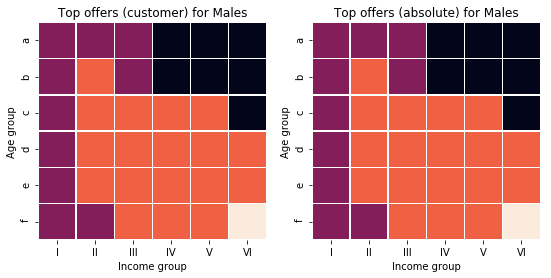

In [67]:
# results for Males
display('Top offers (customer) for Males', top_offer_cust_M)
print('\n')
display('Top offers (absolute) for Males', top_offer_abs_M)
print('\n')

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.heatmap(top_offer_cust_M2, center=1.5, cmap='rocket',\
            annot=False, linewidths=.5, cbar=False, ax=ax1)
ax1.title.set_text("Top offers (customer) for Males")
ax1.set_xlabel("Income group");
ax1.set_ylabel("Age group");

sns.heatmap(top_offer_abs_M2, center=1.5, cmap='rocket',\
            annot=False, linewidths=.5, cbar=False, ax=ax2)
ax2.title.set_text("Top offers (absolute) for Males")
ax2.set_xlabel("Income group");
ax2.set_ylabel("Age group");


In the above heatmaps, the colours represent:
- Purple: Informational offer
- Orange: Discount offer
- Beige: BOGO offer
- Black: No applicable offer

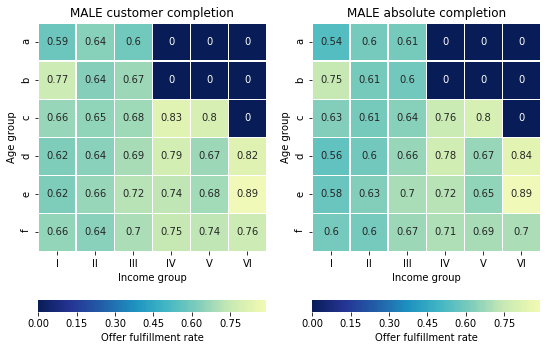

In [68]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
#sns.heatmap(top_offer_percent_cust_M, center=0.5, cmap='BrBG', annot=True)
sns.heatmap(top_offer_percent_cust_M, center=0.5, cmap='YlGnBu_r',\
            annot=True, linewidths=.5, cbar_kws={'label': 'Offer fulfillment rate', 'orientation': 'horizontal'}, ax=ax1)
ax1.title.set_text("MALE customer completion")
ax1.set_xlabel("Income group");
ax1.set_ylabel("Age group");

sns.heatmap(top_offer_percent_abs_M, center=0.5, cmap='YlGnBu_r',\
            annot=True, linewidths=.5, cbar_kws={'label': 'Offer fulfillment rate', 'orientation': 'horizontal'}, ax=ax2)
ax2.title.set_text("MALE absolute completion")
ax2.set_xlabel("Income group");
ax2.set_ylabel("Age group");

The above two heatmaps show the fulfillment ratio of the top offer in each demographic.

##### 2.1.4.2 Results for Females

The same notes / key apply as for Males.

'Top offers (customer) for Females'

,I,II,III,IV,V,VI
a,offer_5,offer_7,offer_8,None,None,None
b,offer_6,offer_6,offer_5,None,None,None
c,offer_6,offer_6,offer_6,offer_3,offer_5,None
d,offer_6,offer_6,offer_5,offer_6,offer_6,offer_8
e,offer_7,offer_6,offer_6,offer_5,offer_6,offer_6
f,offer_6,offer_5,offer_6,offer_6,offer_5,offer_6


'Top offers (absolute) for Females'

,I,II,III,IV,V,VI
a,offer_6,offer_7,offer_8,None,None,None
b,offer_6,offer_6,offer_6,None,None,None
c,offer_6,offer_6,offer_6,offer_3,offer_6,None
d,offer_6,offer_6,offer_5,offer_6,offer_6,offer_1
e,offer_7,offer_6,offer_6,offer_5,offer_6,offer_6
f,offer_6,offer_5,offer_6,offer_5,offer_5,offer_6


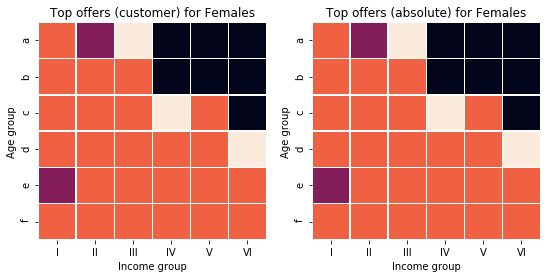

In [69]:
# results for females
display('Top offers (customer) for Females', top_offer_cust_F)
print('\n')
display('Top offers (absolute) for Females', top_offer_abs_F)
print('\n')

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.heatmap(top_offer_cust_F2, center=1.5, cmap='rocket',\
            annot=False, linewidths=.5, cbar=False, ax=ax1)
ax1.title.set_text("Top offers (customer) for Females")
ax1.set_xlabel("Income group");
ax1.set_ylabel("Age group");

sns.heatmap(top_offer_abs_F2, center=1.5, cmap='rocket',\
            annot=False, linewidths=.5, cbar=False, ax=ax2)
ax2.title.set_text("Top offers (absolute) for Females")
ax2.set_xlabel("Income group");
ax2.set_ylabel("Age group");

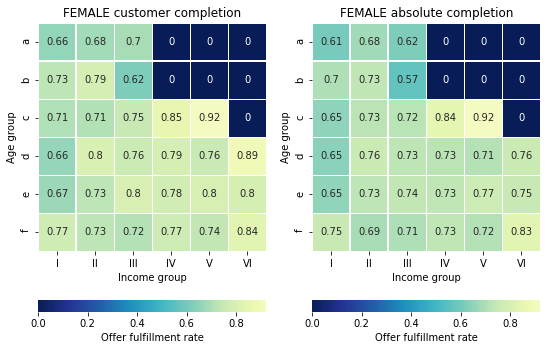

In [70]:
# results for Females

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.heatmap(top_offer_percent_cust_F, center=0.5, cmap='YlGnBu_r',\
            annot=True, linewidths=.5, cbar_kws={'label': 'Offer fulfillment rate', 'orientation': 'horizontal'}, ax=ax1)
ax1.title.set_text("FEMALE customer completion")
ax1.set_xlabel("Income group");
ax1.set_ylabel("Age group");

sns.heatmap(top_offer_percent_abs_F, center=0.5, cmap='YlGnBu_r',\
            annot=True, linewidths=.5, cbar_kws={'label': 'Offer fulfillment rate', 'orientation': 'horizontal'}, ax=ax2)
ax2.title.set_text("FEMALE absolute completion")
ax2.set_xlabel("Income group");
ax2.set_ylabel("Age group");

##### 2.1.4.3 Results for Other

The same notes / key apply as for Males and Females. 

'Top offers (customer) for Other'

,I,II,III,IV,V,VI
a,offer_6,offer_0,offer_1,None,None,None
b,offer_3,offer_2,offer_0,None,None,None
c,offer_3,offer_5,offer_2,offer_0,offer_1,None
d,offer_5,offer_8,offer_0,offer_9,offer_1,None
e,offer_0,offer_5,offer_5,offer_1,offer_0,None
f,offer_7,offer_8,offer_1,offer_4,offer_2,None


'Top offers (absolute) for Other'

,I,II,III,IV,V,VI
a,offer_6,offer_0,offer_1,None,None,None
b,offer_3,offer_2,offer_0,None,None,None
c,offer_8,offer_6,offer_2,offer_0,offer_1,None
d,offer_5,offer_0,offer_5,offer_9,offer_5,None
e,offer_1,offer_6,offer_5,offer_1,offer_2,None
f,offer_7,offer_8,offer_1,offer_4,offer_2,None


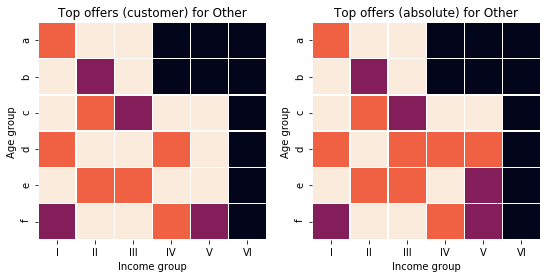

In [71]:
# results for other
display('Top offers (customer) for Other', top_offer_cust_O)
print('\n')
display('Top offers (absolute) for Other', top_offer_abs_O)
print('\n')

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.heatmap(top_offer_cust_O2, center=1.5, cmap='rocket',\
            annot=False, linewidths=.5, cbar=False, ax=ax1)
ax1.title.set_text("Top offers (customer) for Other")
ax1.set_xlabel("Income group");
ax1.set_ylabel("Age group");

sns.heatmap(top_offer_abs_O2, center=1.5, cmap='rocket',\
            annot=False, linewidths=.5, cbar=False, ax=ax2)
ax2.title.set_text("Top offers (absolute) for Other")
ax2.set_xlabel("Income group");
ax2.set_ylabel("Age group");

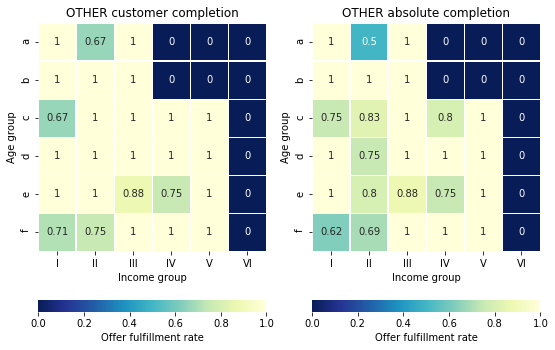

In [72]:
# results for Others
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.heatmap(top_offer_percent_cust_O, center=0.5, cmap='YlGnBu_r',\
            annot=True, linewidths=.5, cbar_kws={'label': 'Offer fulfillment rate', 'orientation': 'horizontal'}, ax=ax1)
ax1.title.set_text("OTHER customer completion")
ax1.set_xlabel("Income group");
ax1.set_ylabel("Age group");

sns.heatmap(top_offer_percent_abs_O, center=0.5, cmap='YlGnBu_r',\
            annot=True, linewidths=.5, cbar_kws={'label': 'Offer fulfillment rate', 'orientation': 'horizontal'}, ax=ax2)
ax2.title.set_text("OTHER absolute completion")
ax2.set_xlabel("Income group");
ax2.set_ylabel("Age group");

We note that the results have a much less regular pattern for "Other", likely due to the small number of "Other" customers in our data.

## 2.2 Machine Learning Modelling

In this section we use machine learning create models to predict whether a given offer will be fulfilled.

### 2.2.1 Further data preparation

In [73]:
prof_cleaned = profile2_cleaned.reset_index(drop=True)

In [74]:
### Adding a feature to the data: number of days of membership for each customer

In [75]:
def calc_member_days(join_date):
    '''
    Purpose: calculate the number of days that a customer has been a member, taking the reference date as 
    2018/7/26 which is the most recent joining date out of all customers, from the profile dataframe
    Input: join_date = "became_member_on" from the prof_cleaned dataframe
    Output: diff.days = number of days customer was a member
    '''
    join_date = str(join_date)
    year = join_date[0:4]
    month = join_date[4:6]
    month = month.lstrip('0') # remove any leading zero
    day = join_date[6:8]
    day = day.lstrip('0') # remove any leading zero
    
    djoin = date(int(year), int(month), int(day))
    dmax = date(2018,7,26) # most recent joining date from all customers
    diff = dmax - djoin
    
    return diff.days

In [76]:
prof_cleaned['member_time'] = prof_cleaned['became_member_on'].apply(calc_member_days)

In [77]:
# # delete columns not used further
del prof_cleaned["became_member_on"]
del prof_cleaned["age_group"]
del prof_cleaned["income_group"]

In [78]:
prof_cleaned.head(10)

,age,gender,customer,income,member_time
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,91
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,167
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257
5,61,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,318
6,26,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,1624
7,62,F,31dda685af34476cad5bc968bdb01c53,71000.0,896
8,49,M,62cf5e10845442329191fc246e7bcea3,52000.0,1351
9,57,M,6445de3b47274c759400cd68131d91b4,42000.0,207


In [79]:
# one-hot encode gender data
prof_cleaned['M'] = 0
prof_cleaned['F'] = 0
prof_cleaned['O'] = 0

In [80]:
prof_cleaned['M'] = prof_cleaned['gender'].apply(lambda x: 'M' in x) * 1
prof_cleaned['F'] = prof_cleaned['gender'].apply(lambda x: 'F' in x) * 1
prof_cleaned['O'] = prof_cleaned['gender'].apply(lambda x: 'O' in x) * 1

In [81]:
# remove columns that will not be used to train the model
del prof_cleaned["gender"]

In [82]:
prof_cleaned = prof_cleaned.reindex(columns = ['customer', 'age', 'M', 'F', 'O', 'income', 'member_time'])

In [83]:
prof_cleaned.head()

,customer,age,M,F,O,income,member_time
0,0610b486422d4921ae7d2bf64640c50b,55,0,1,0,112000.0,376
1,78afa995795e4d85b5d9ceeca43f5fef,75,0,1,0,100000.0,443
2,e2127556f4f64592b11af22de27a7932,68,1,0,0,70000.0,91
3,389bc3fa690240e798340f5a15918d5c,65,1,0,0,53000.0,167
4,2eeac8d8feae4a8cad5a6af0499a211d,58,1,0,0,51000.0,257


#### 2.2.1.1 The consolidated dataframe that will be the basis for machine learning modelling

In [84]:
# prepare full dataframe that includes both target and dependent variables 
# containing demographic, offer received, viewed and fulfilled data, plus transaction values and occurences
# associated with each customer
filter_unknown = user_offer_all['person'].isin(prof_cleaned['customer'])

In [85]:
user_offer_known = user_offer_all[filter_unknown]

In [86]:
user_trans_known = user_trans[filter_unknown]

In [87]:
customer_offer = pd.merge(prof_cleaned, user_offer_known, left_on='customer', right_on='person', \
                          how='left').drop('person', axis=1)

In [88]:
# combined data set containing demographic, offer received, viewed and fulfilled data, plus transaction values and occurences
# associated with each customer
customer_offer_trans = pd.merge(customer_offer, user_trans_known, left_on='customer', right_on='person', \
                          how='left').drop('person', axis=1)

In [89]:
customer_offer_trans.head()

,customer,age,M,F,O,income,member_time,offer_0r,offer_1r,offer_2r,...,offer_2tval,offer_3tval,offer_4tval,offer_5tval,offer_6tval,offer_7tval,offer_8tval,offer_9tval,all_trans_val,n_all_trans
0,0610b486422d4921ae7d2bf64640c50b,55,0,1,0,112000.0,376,0,0,1,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,77.01,3
1,78afa995795e4d85b5d9ceeca43f5fef,75,0,1,0,100000.0,443,1,0,0,...,0.0,19.89,0.0,0.0,0.00,19.67,0.00,0.00,159.27,7
2,e2127556f4f64592b11af22de27a7932,68,1,0,0,70000.0,91,0,0,1,...,0.0,18.42,0.0,0.0,18.42,0.00,0.00,0.00,57.73,3
3,389bc3fa690240e798340f5a15918d5c,65,1,0,0,53000.0,167,0,0,0,...,0.0,15.63,0.0,0.0,11.26,0.00,9.54,15.63,36.43,3
4,2eeac8d8feae4a8cad5a6af0499a211d,58,1,0,0,51000.0,257,0,0,1,...,0.0,0.00,0.0,0.0,7.14,0.00,0.00,0.00,15.62,4


In [90]:
customer_offer_trans.columns

Index(['customer', 'age', 'M', 'F', 'O', 'income', 'member_time', 'offer_0r',
       'offer_1r', 'offer_2r', 'offer_3r', 'offer_4r', 'offer_5r', 'offer_6r',
       'offer_7r', 'offer_8r', 'offer_9r', 'offer_0c', 'offer_1c', 'offer_2c',
       'offer_3c', 'offer_4c', 'offer_5c', 'offer_6c', 'offer_7c', 'offer_8c',
       'offer_9c', 'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v',
       'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v',
       'offer_0_fr', 'offer_1_fr', 'offer_2_fr', 'offer_3_fr', 'offer_4_fr',
       'offer_5_fr', 'offer_6_fr', 'offer_7_fr', 'offer_8_fr', 'offer_9_fr',
       'offer_0tval', 'offer_1tval', 'offer_2tval', 'offer_3tval',
       'offer_4tval', 'offer_5tval', 'offer_6tval', 'offer_7tval',
       'offer_8tval', 'offer_9tval', 'all_trans_val', 'n_all_trans'],
      dtype='object')

### 2.2.2 Regression model

**Aim** In this section, we will train a regression model to predict whether a customer fulfills an offer they received, i.e. the fulfillment ratio of a given order.

#### 2.2.2.1 Data split

For a given offer, *offer_x,* the target variable is *offer_x_fr,* which is the rate of completion (i.e. fulfillment ratio) of that offer.

However, we know that many customers will not have viewed *offer_x*, or even received it. So we exclude those customers from the dataset. We are interested to know how customers react to the offer they view (i.e. are aware of). We do not count the customers who inadvertantly fulfill an offer they do not even know existed.

This approach means using a different dataset, and hence training a different model for each offer.
If we didn't do things this way, but tried to train a single model containing all customers , and all offers in the dataset
 there is the possibility that, when using a regression approach, we may get the result that a customer
 may be predicted to have a non-zero geniune completion on an offer that they did not even view.


##### 2.2.2.2 Model for offer_6

First attempt, is to examine, *offer_6*, a popular discount offer (as can been seen from Sections 2.1.4.1 and 2.1.4.2). The target variable is the fulfillment ratio for this offer, i.e. *offer_6_fr*. We are interested to know if the following features enable us to reliably predict the ratio:

**Demographic information about the customer**
* age
* gender
* income

**Behavioural information about the customer**
* how many days the customer has been a member
* how much money the customer has spent in Starbucks (excluding money spent associated with *offer_6*)
* how many transactions the customer has made (excluding those associated with *offer_6*)

**Other information**
* how many instances of this offer the customer has viewed

We normalize the dataset, to improve model performance. For the modelling, we use Linear Regression, allowing polynomial terms of up to degree 8, and allowing cross-coupling of feature variables.

We use LASSO Regularization, to nullify the effect of features that the model finds to be less significant, and cross validation to get a better idea of whether the accuracy results of the model can be generalized to other data sets.

In [91]:
# model for offer 6 - a popular offer
# filter for those who have viewed the offer
filter_offer = customer_offer_trans['offer_6v'] >= 1e-6 # "zero" with tolerance, allowing for floating point error

customer_offer_trans_6 = customer_offer_trans[filter_offer]

In [92]:
# target variable
ydata = customer_offer_trans_6['offer_6_fr']

In [93]:
# features

In [94]:
customer_offer_trans_6.head()

,customer,age,M,F,O,income,member_time,offer_0r,offer_1r,offer_2r,...,offer_2tval,offer_3tval,offer_4tval,offer_5tval,offer_6tval,offer_7tval,offer_8tval,offer_9tval,all_trans_val,n_all_trans
2,e2127556f4f64592b11af22de27a7932,68,1,0,0,70000.0,91,0,0,1,...,0.00,18.42,0.0,0.00,18.42,0.00,0.00,0.00,57.73,3
3,389bc3fa690240e798340f5a15918d5c,65,1,0,0,53000.0,167,0,0,0,...,0.00,15.63,0.0,0.00,11.26,0.00,9.54,15.63,36.43,3
4,2eeac8d8feae4a8cad5a6af0499a211d,58,1,0,0,51000.0,257,0,0,1,...,0.00,0.00,0.0,0.00,7.14,0.00,0.00,0.00,15.62,4
7,31dda685af34476cad5bc968bdb01c53,62,0,1,0,71000.0,896,0,0,0,...,0.00,0.00,0.0,24.87,12.57,0.00,0.00,0.00,160.25,8
13,c27e0d6ab72c455a8bb66d980963de60,78,0,1,0,71000.0,405,0,1,2,...,13.25,0.00,0.0,0.00,25.27,25.27,0.00,0.00,155.46,8


In [95]:
customer_offer_trans_6.columns

Index(['customer', 'age', 'M', 'F', 'O', 'income', 'member_time', 'offer_0r',
       'offer_1r', 'offer_2r', 'offer_3r', 'offer_4r', 'offer_5r', 'offer_6r',
       'offer_7r', 'offer_8r', 'offer_9r', 'offer_0c', 'offer_1c', 'offer_2c',
       'offer_3c', 'offer_4c', 'offer_5c', 'offer_6c', 'offer_7c', 'offer_8c',
       'offer_9c', 'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v',
       'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v',
       'offer_0_fr', 'offer_1_fr', 'offer_2_fr', 'offer_3_fr', 'offer_4_fr',
       'offer_5_fr', 'offer_6_fr', 'offer_7_fr', 'offer_8_fr', 'offer_9_fr',
       'offer_0tval', 'offer_1tval', 'offer_2tval', 'offer_3tval',
       'offer_4tval', 'offer_5tval', 'offer_6tval', 'offer_7tval',
       'offer_8tval', 'offer_9tval', 'all_trans_val', 'n_all_trans'],
      dtype='object')

In [96]:
# add column for transactions that aren't transactions related to offer_6
# this is a measure of the "spending habits" of the customer 'before' offer_6 is issued to the customer
Xdata = customer_offer_trans_6.copy()

In [97]:
Xdata['non_offer_6_trans_val'] = Xdata['all_trans_val'] - Xdata['offer_6tval'] # value of transactions exc. the current offer
Xdata['n_non_offer_6'] = Xdata['n_all_trans'] - Xdata['offer_6c'] # number of transaction exc. current offer

In [98]:
variables_dependent = ['age', 'M', 'F', 'O', 'income', 'member_time', 'offer_6v', 'non_offer_6_trans_val', 'n_non_offer_6']
Xdata = Xdata[variables_dependent]

In [99]:
Xdata.head()

,age,M,F,O,income,member_time,offer_6v,non_offer_6_trans_val,n_non_offer_6
2,68,1,0,0,70000.0,91,1,39.31,2
3,65,1,0,0,53000.0,167,1,25.17,2
4,58,1,0,0,51000.0,257,1,8.48,3
7,62,0,1,0,71000.0,896,2,147.68,7
13,78,0,1,0,71000.0,405,1,130.19,7


In [100]:
# Initialize a scaler, then apply it to all numerical features, i.e. all except genders M, F, O
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'income', 'member_time', 'offer_6v', 'non_offer_6_trans_val', 'n_non_offer_6']

Xdata_scaled = pd.DataFrame(data = Xdata)
Xdata_scaled[numerical] = scaler.fit_transform(Xdata[numerical])

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size = 0.2, random_state = 1)

In [102]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4301 samples.
Testing set has 1076 samples.


In [103]:
# LASSO regularisation parameters
lasso_eps = 0.02
lasso_nalpha = 20
lasso_iter = 5000

In [104]:
# degree of polynomial features
degree_min = 2
degree_max = 8

In [105]:
# Pipeline model with polynomial transformation and LASSO regression and cross-validation
RMSE_vec = []
test_score_vec = []
for degree in range(degree_min, degree_max+1):
    print(degree, end=" ")
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), \
                          LassoCV(eps=lasso_eps, n_alphas=lasso_nalpha, max_iter=lasso_iter, normalize=True, cv=3))
    model.fit(X_train, y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE = np.sqrt(np.sum(np.square(test_pred - y_test)))
    RMSE_vec.append(RMSE)
    test_score = model.score(X_test, y_test)
    test_score_vec.append(test_score)

2 3 4 5 6 7 8 

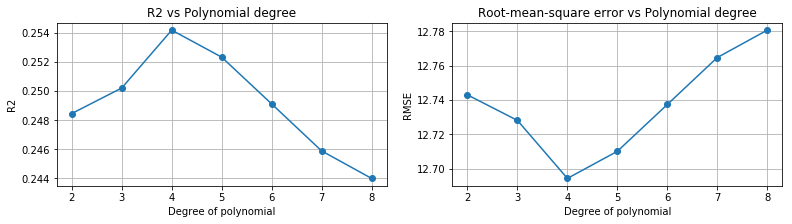

In [106]:
# Plot results

f = plt.figure(figsize=(13,3))

plt.subplot(1,2,1)
plt.plot(range(degree_min, degree_max+1), test_score_vec, marker='o')
plt.title('R2 vs Polynomial degree')
plt.xlabel('Degree of polynomial')
plt.ylabel('R2')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(degree_min, degree_max+1), RMSE_vec, marker='o')
plt.title('Root-mean-square error vs Polynomial degree')
plt.xlabel('Degree of polynomial')
plt.ylabel('RMSE')
plt.grid(True)

plt.show()

The results show that the model does not perform well, with R2 being approximately 0.25, and RMSE approxumately 12.7. There is little increase in accuracy as the degree of polynomial increases. 
 

Since we have used a high degree polynomial, it is likely that what is lacking is one or more key features being used in model training. However, we have used all the demographic information, and our choice of  behavioural features is reasonable.  Increases in the number of features and degree of the polynomial significantly increase computation time and memory demands (memory errors were encountered for the same approach but with a few more features).

As the accuracy rate is this low, a change of method, e.g. to SWM is unlikely to significantly increase accuracy to an acceptable level.

The root cause of the issue is likely to be that our feature data does not contain the key data required to get a reliable and precise regression model to answer our original aim. Therefore we are likely to get the same result with this approach if we apply it to other offers, and so we move to another approach in the next section.

### 2.2.3 Classification model

**AIM:** Instead of trying to predict fulfillment rate of an offer (regression approach) we try to predict simply if an offer will be fulfilled or not (a binary classification problem). Again we start with *offer_6*, a discount offer.

The target variable is now whether the offer is fulfilled or not (1 for yes, 0 for no).
Since the classification models are less computationally intensive to train, we increase the number of features, in response to what we found in Section 2.2.2: that we did not have at least one key feature in our training set. For our classification model, we will add data on how many instances of each offer, not just this offer, but all the rest the customer has viewed. If a customer has viewed a lot of offers, it may mean that the customer is keen on offers, that the customer has received a lot of offers from Starbucks (and the more offers someone receives, the more offers are taken up), or that through knowing what other offers come the customer's way, the customer can compare the attactiveness of *offer_6* to the others, which may influence the customer's uptake of *offer_6*. Or there may be fatigue from seeing too many offers, which makes the customer less open to new ones. 

We will tackle the aim using two different methods, logistic regression and the decision tree classifier.


In [107]:
# Model for offer_6
# converting target variable into 0 or 1
ydata_cf = (ydata > 1e-6) * 1 

In [108]:
## prepare new features (offers viewed), other offers, transactions

Xdata_cf = customer_offer_trans_6.copy()

Xdata_cf['non_offer_6_trans_val'] = Xdata_cf['all_trans_val'] - Xdata_cf['offer_6tval'] # value of transactions exc. the current offer
Xdata_cf['n_non_offer_6'] = Xdata_cf['n_all_trans'] - Xdata_cf['offer_6c'] # number of transaction exc. current offer

variables_dependent_cf = ['age', 'M', 'F', 'O', 'income', 'member_time', \
                          'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', \
                          'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v', \
                          'non_offer_6_trans_val', 'n_non_offer_6']
Xdata_cf = Xdata_cf[variables_dependent_cf]

In [109]:
# Initialize a scaler, then apply it to all numerical features, i.e. all except genders M, F, O
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'income', 'member_time', \
            'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', \
            'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v', \
            'non_offer_6_trans_val', 'n_non_offer_6']

Xdata_scaled_cf = pd.DataFrame(data = Xdata_cf)
Xdata_scaled_cf[numerical] = scaler.fit_transform(Xdata_scaled_cf[numerical])

In [110]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xdata_scaled_cf, ydata_cf, test_size = 0.2, random_state = 1)

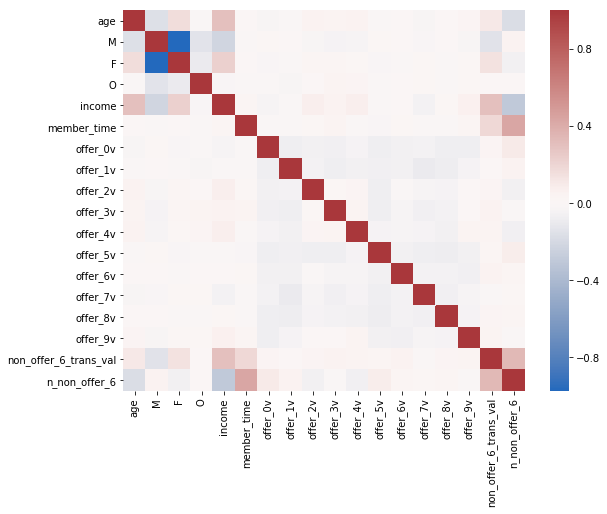

In [111]:
# Correlation between the features
fig = plt.figure(figsize=(9,7))
sns.heatmap(Xdata_scaled_cf.corr(), cmap='vlag');

The correlation heatmap shows relatively little correlation, positive or negative, for most features, (except between "M" and "F", which is to be expected). 

#### 2.2.3.1 Logistic regression

In [112]:
# initiate regressor
logistic_regression= LogisticRegression(max_iter = 5000, C=10)

In [113]:
# Use cross_validation prediction
y_pred = cross_validation.cross_val_predict(logistic_regression, X_train, y_train, cv=10)

In [114]:
print(metrics.accuracy_score(y_train, y_pred))

0.776796093932


In [115]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [116]:
y_pred = logistic_regression.predict(X_test)

In [117]:
# Here is the final accuracy
print(metrics.accuracy_score(y_test, y_pred)) 

0.783457249071


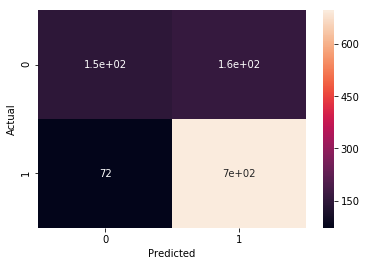

In [118]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

In [119]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.48      0.56       307
          1       0.81      0.91      0.86       769

avg / total       0.77      0.78      0.77      1076



The overall score is fairly good. However, we note a relatively high level of false positives.

In [120]:
# Look at feature importance
importances = logistic_regression.coef_[0]
for i,v in enumerate(importances):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.21067
Feature: 1, Score: -0.49839
Feature: 2, Score: -0.22447
Feature: 3, Score: -0.73848
Feature: 4, Score: 1.50661
Feature: 5, Score: 2.34747
Feature: 6, Score: 0.26014
Feature: 7, Score: -0.28051
Feature: 8, Score: 1.44254
Feature: 9, Score: 0.17243
Feature: 10, Score: 0.65657
Feature: 11, Score: -0.20359
Feature: 12, Score: 2.79574
Feature: 13, Score: -0.13266
Feature: 14, Score: -0.27996
Feature: 15, Score: 0.22111
Feature: 16, Score: 2.52612
Feature: 17, Score: 4.80113


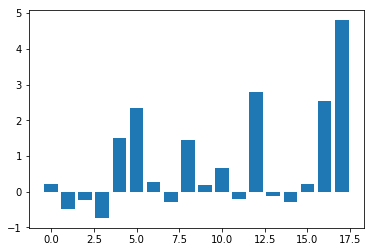

In [121]:
plt.bar([x for x in range(len(importances))], importances)
plt.show()

The key feature is Feature 16, which is the amount the customer has spent (excluding on *offer_6*). The next most significant features have much less weight. These are Features 0, 4 and 5, which are the demographic information (age and income) and the length of time spent as a member. Surprisingly, gender has little influence, as have other offers the customer views. 

#### 2.2.3.2 Decision tree classifier

In [122]:
clf_DT = DecisionTreeClassifier(random_state=1)
model = clf_DT.fit(X_train, y_train)

In [123]:
y_pred = cross_validation.cross_val_predict(model, X_train, y_train, cv=10)

In [124]:
print(metrics.accuracy_score(y_train, y_pred))

0.700767263427


In [125]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [126]:
y_pred = model.predict(X_test)

In [127]:
# Here is the final accuracy
print(metrics.accuracy_score(y_test, y_pred)) 

0.67936802974


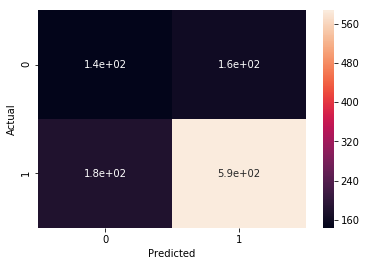

In [128]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

In [129]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.44      0.47      0.45       307
          1       0.78      0.76      0.77       769

avg / total       0.69      0.68      0.68      1076



The performance is worse than Logistic Regression. In particular, there are quite high levels of false negatives now as well.

In [130]:
importances = clf_DT.feature_importances_

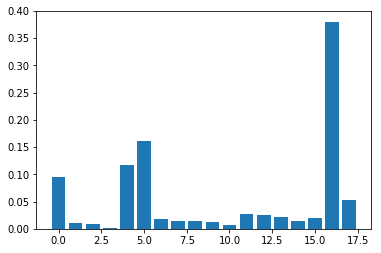

In [131]:
plt.bar([x for x in range(len(importances))], importances);

The same features are the most important as for Logistic Regression.

#### 2.2.3.3 Analysis on other offers

Using Logistic Regression, we repeat the analysis on a selection of other offers. We choose *offer_5*, a BOGO offer, and *offer_7* an informational offer, to see if there are any significant differences in the results. 

###### 2.2.3.3.1 Offer_5

In [132]:
# Filter data for customers who view offer_5
filter_offer = customer_offer_trans['offer_5v'] >= 1e-6 # "zero" with tolerance, allowing for floating point error
customer_offer_trans_5 = customer_offer_trans[filter_offer]

In [133]:
# Target variable
ydata = customer_offer_trans_5['offer_5_fr']
ydata_cf5 = (ydata > 1e-6) * 1 

In [134]:
## prepare new features (offers viewed), other offers, transactions

Xdata_cf5 = customer_offer_trans_5.copy()

Xdata_cf5['non_offer_5_trans_val'] = Xdata_cf5['all_trans_val'] - Xdata_cf5['offer_5tval'] # value of transactions exc. the current offer
Xdata_cf5['n_non_offer_5'] = Xdata_cf5['n_all_trans'] - Xdata_cf5['offer_5c'] # number of transaction exc. current offer

variables_dependent_cf = ['age', 'M', 'F', 'O', 'income', 'member_time', \
                          'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', \
                          'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v', \
                          'non_offer_5_trans_val', 'n_non_offer_5']
Xdata_cf5 = Xdata_cf5[variables_dependent_cf]

In [135]:
# Initialize a scaler, then apply it to all numerical features, i.e. all except genders M, F, O
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'income', 'member_time', \
            'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', \
            'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v', \
            'non_offer_5_trans_val', 'n_non_offer_5']

Xdata_scaled_cf5 = pd.DataFrame(data = Xdata_cf5)
Xdata_scaled_cf5[numerical] = scaler.fit_transform(Xdata_scaled_cf5[numerical])

In [136]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xdata_scaled_cf5, ydata_cf5, test_size = 0.2, random_state = 1)

In [137]:
# initiate regressor
logistic_regression= LogisticRegression(max_iter = 5000, C=10)

In [138]:
# Use cross_validation prediction
y_pred = cross_validation.cross_val_predict(logistic_regression, X_train, y_train, cv=10)

In [139]:
print(metrics.accuracy_score(y_train, y_pred))

0.749530516432


In [140]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [141]:
y_pred = logistic_regression.predict(X_test)

In [142]:
# Here is the final accuracy
print(metrics.accuracy_score(y_test, y_pred)) 

0.723943661972


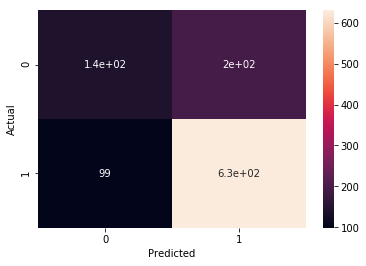

In [143]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

In [144]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.59      0.42      0.49       336
          1       0.76      0.86      0.81       729

avg / total       0.71      0.72      0.71      1065



Similar, but slightly worse result, compared to *offer_6*.

###### 2.2.3.3.1 Offer_7

In [145]:
# Filter data for customers who view offer_5
filter_offer = customer_offer_trans['offer_7v'] >= 1e-6 # "zero" with tolerance, allowing for floating point error
customer_offer_trans_7 = customer_offer_trans[filter_offer]

In [146]:
# Target variable
ydata = customer_offer_trans_7['offer_7_fr']
ydata_cf7 = (ydata > 1e-6) * 1 

In [147]:
## prepare new features (offers viewed), other offers, transactions

Xdata_cf7 = customer_offer_trans_7.copy()

Xdata_cf7['non_offer_7_trans_val'] = Xdata_cf7['all_trans_val'] - Xdata_cf7['offer_7tval'] # value of transactions exc. the current offer
Xdata_cf7['n_non_offer_7'] = Xdata_cf7['n_all_trans'] - Xdata_cf7['offer_7c'] # number of transaction exc. current offer

variables_dependent_cf = ['age', 'M', 'F', 'O', 'income', 'member_time', \
                          'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', \
                          'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v', \
                          'non_offer_7_trans_val', 'n_non_offer_7']
Xdata_cf7 = Xdata_cf7[variables_dependent_cf]

In [148]:
# Initialize a scaler, then apply it to all numerical features, i.e. all except genders M, F, O
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'income', 'member_time', \
            'offer_0v', 'offer_1v', 'offer_2v', 'offer_3v', 'offer_4v', \
            'offer_5v', 'offer_6v', 'offer_7v', 'offer_8v', 'offer_9v', \
            'non_offer_7_trans_val', 'n_non_offer_7']

Xdata_scaled_cf7 = pd.DataFrame(data = Xdata_cf7)
Xdata_scaled_cf7[numerical] = scaler.fit_transform(Xdata_scaled_cf7[numerical])

In [149]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xdata_scaled_cf7, ydata_cf7, test_size = 0.2, random_state = 1)

In [150]:
# initiate regressor
logistic_regression= LogisticRegression(max_iter = 5000, C=10)

In [151]:
# Use cross_validation prediction
y_pred = cross_validation.cross_val_predict(logistic_regression, X_train, y_train, cv=10)

In [152]:
print(metrics.accuracy_score(y_train, y_pred))

0.6589827111


In [153]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [154]:
y_pred = logistic_regression.predict(X_test)

In [155]:
# Here is the final accuracy
print(metrics.accuracy_score(y_test, y_pred)) 

0.690380761523


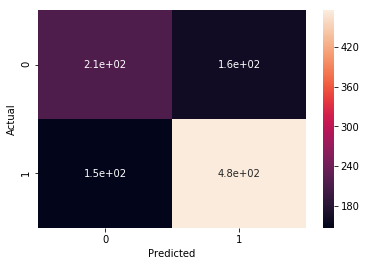

In [156]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True);

In [157]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.59      0.57      0.58       376
          1       0.75      0.76      0.75       622

avg / total       0.69      0.69      0.69       998



Similar, but slightly worse result, compared to *offer_5* and *offer_6*. In particular increased false negatives. This may be because of the ambiguities involved in determining the completion of informational offers (see Section 1.5). 